In [210]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
from sklearn.decomposition import PCA

# Load and Clean Data

In [211]:
surveydata = pd.read_csv('C:/Users/amanda.kaplan/OneDrive - Aristotle/Desktop/Kennedy model/Data for Modeling Project/surveydata.csv',
                        low_memory = False)

In [212]:
#Replace blanks and spaces with NaN
surveydata.replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [213]:
#fill missing values, using median / mode data

replacements = {
    'CENSUS_TRK':0,
    'AGE': surveydata['AGE'].median(),
    'CNS_MEDINC': surveydata['CNS_MEDINC'].mode()[0],
    'CNSUS_PCTA': surveydata['CNSUS_PCTA'].median(),
    'CNSUS_PCTB':surveydata['CNSUS_PCTB'].median(),
    'CNSUS_PCTH':surveydata['CNSUS_PCTH'].median(),
    'CNSUS_PCTI':surveydata['CNSUS_PCTI'].median(),
    'CNSUS_PCTM':surveydata['CNSUS_PCTM'].median(),
    'CNSUS_PCTO':surveydata['CNSUS_PCTO'].median(),
    'CNSUS_PCTP':surveydata['CNSUS_PCTP'].median(), 
    'CNSUS_PCTW':surveydata['CNSUS_PCTW'].median(), 
    'CONG_DIST': '000',
    'COUNTY_TYPE': 'UNK',
    'CREDRATE':'UNK',
    'DON_POLIT': 'N',
    'DON_CHARIT':'N',
    'DON_RELIG':'N',
    'DON_HEALTH':'N',
    'PRFL_ENVIRONMENT':'N',
    'EDUCATION': surveydata['EDUCATION'].mode()[0],
    'ETHNICCODE':'UNK',
    'ETHNIC_INFER': surveydata['ETHNIC_INFER'].mode()[0],
    'HOMEMKTVAL': surveydata['HOMEMKTVAL'].mode()[0],
    'HOMEOWNRNT':surveydata['HOMEOWNRNT'].mode()[0],
    'INCOMESTHH':surveydata['INCOMESTHH'].mode()[0],
    'LIFESTAGE_CLUSTER':'UNK',
    'LANGUAGE':'UNK',
    'NETWORTH':surveydata['NETWORTH'].mode()[0],
    'PRESENCHLD':'N',
    'PRFL_VETERAN':'N',
    'PRFL_2NDAMEND':'N',
    'PRFL_BIDEN_SUPPORT':'N',
    'PRFL_BORDER_SECURITY':'N',
    'PRFL_EVANGELICAL':'N',
    'PRFL_IMMIGRATION_REFORM':'N',
    'PRFL_POLITICAL_IDEOLOGY':'UNK',
    'PRFL_ANML_RIGHTS':'N',
    'PRFL_EDUCATION':'N',
    'PRFL_GUN_CONTROL':'N',
    'PRFL_TRUMP_SUPPORT':'N',
    'PRFL_FENCE_SITTER':'N',
    'PRFL_PERSUADABLE_VOTER':'N',
    'PRFL_MARRIAGE_EQUALITY':0,
    'PRFL_METOO_SUPPORT':'N',
    'PRFL_MIL_SUPPORT':'N',
    'PRFL_MINWAGE':0,
    'PRFL_CHOICELIFE':0,
    'PRFL_LIBERAL_NEWS':'N',
    'PRFL_CONSERVATIVE_NEWS':'N',
    'RELIGION':surveydata['RELIGION'].mode()[0],
    'SEX':'UNK',
    'ST_LO_HOUS':'000',
    'ST_UP_HOUS':'00',
    'TOD_PRES_D_2016': surveydata['TOD_PRES_D_2016'].median(),
    'TOD_PRES_D_2016_PREC': surveydata['TOD_PRES_D_2016_PREC'].median(),
    'TOD_PRES_D_2020_PREC' : surveydata['TOD_PRES_D_2020_PREC'].median(),
    'TOD_PRES_O_2016' : surveydata['TOD_PRES_O_2016'].median(),
    'TOD_PRES_O_2016_PREC': surveydata['TOD_PRES_O_2016_PREC'].median(),
    'TOD_PRES_O_2020_PREC': surveydata['TOD_PRES_O_2020_PREC'].median(),
    'TOD_PRES_R_2016' : surveydata['TOD_PRES_R_2016'].median(),
    'TOD_PRES_R_2016_PREC': surveydata['TOD_PRES_R_2016_PREC'].median(),
    'TOD_PRES_R_2020_PREC': surveydata['TOD_PRES_R_2020_PREC'].median(),
    'ZIP': '-9999',
    'VP_GEN':0,
    'VP_PRI':0,
    'VP_PPP':0,
    'VP_OTH':0
}

# Fill NaNs
for col, value in replacements.items():
    surveydata[col].fillna(value, inplace=True)

In [214]:
#party code needs some adjustment for a few states after researching with Riley
#RI, DC, LA change U to N
#OK change I to N

surveydata.loc[(surveydata['STATE'].isin(['LA', 'DC', 'RI'])) & (surveydata['PARTY_CODE'] == 'U'), 'PARTY_CODE'] = 'N'
surveydata.loc[(surveydata['STATE'] == 'OK') & (surveydata['PARTY_CODE'] == 'I'), 'PARTY_CODE'] = 'N'

# Feature Engineering

In [215]:
#add additional features

# R_donor
surveydata['R_DONOR'] = ((surveydata['FUND_POLIT'] == 'R') | (surveydata['DON_POLCONS'] > '')).astype(int)

# D_donor
surveydata['D_DONOR'] = ((surveydata['FUND_POLIT'] == 'D') | (surveydata['DON_POLLIB'] > '')).astype(int)

# Voted_R_Election
vtr_columns_r = [col for col in surveydata.columns if col.startswith('VTR_')]
condition_r = surveydata[vtr_columns_r].isin(['R', 'P', 'X']).sum(axis=1)
surveydata['VOTED_R_ELECTION'] = condition_r.astype(int)

# Voted_D_Election
vtr_columns_d = [col for col in surveydata.columns if col.startswith('VTR_')]
condition_d = surveydata[vtr_columns_d].isin(['D', 'M', 'Z']).sum(axis=1)
surveydata['VOTED_D_ELECTION'] = condition_d

#additional engineered features to make unique county , congressional , state upper house & state lower house columns
#because county , congressional and house district codes repeat across states
surveydata['STATE_COUNTY_FIPS'] = surveydata['CENSUS_ST'].astype(str) + surveydata['COUNTY_ST'].astype(str)
surveydata['STATE_CD'] = surveydata['CENSUS_ST'].astype(str) + surveydata['CONG_DIST'].astype(str)
surveydata['STATE_LOWER_HOUSE'] = surveydata['CENSUS_ST'].astype(str) + surveydata['ST_LO_HOUS'].astype(str)
surveydata['STATE_UPPER_HOUSE'] = surveydata['CENSUS_ST'].astype(str) + surveydata['ST_UP_HOUS'].astype(str)
surveydata['CENSUS_TRACT'] = surveydata['CENSUS_ST'].astype(str) + surveydata['COUNTY_ST'].astype(str)+ surveydata['CENSUS_TRK'].astype(str)

#add a feature for number of absentee votes
vtr_columns = [col for col in surveydata.columns if col.startswith('VTR_')]
surveydata['ABSENTEE_VOTES'] = surveydata[vtr_columns].apply(lambda row: sum(row.isin(['A', 'X', 'Z'])), axis=1)

#add a feature for number of primary votes
vtr_p_columns = [col for col in surveydata.columns if col.startswith('VTR_P')]
surveydata['NUM_PRIMARY_VOTES'] = surveydata[vtr_p_columns].apply(lambda row: row.notna().sum(), axis=1)

#add a feature for voted absentee in general 2022
surveydata['ABS_2022'] = (surveydata['VTR_GEN22'] == 'A').astype(int)


C:\Users\amanda.kaplan\AppData\Local\Temp\ipykernel_23116\1236061140.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  surveydata['R_DONOR'] = ((surveydata['FUND_POLIT'] == 'R') | (surveydata['DON_POLCONS'] > '')).astype(int)
C:\Users\amanda.kaplan\AppData\Local\Temp\ipykernel_23116\1236061140.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  surveydata['D_DONOR'] = ((surveydata['FUND_POLIT'] == 'D') | (surveydata['DON_POLLIB'] > '')).astype(int)


# Preprocessing

In [216]:
#consolidate target column of interest

candidates_to_replace1 = [
    "Governor Doug Burgum",
    "Former Governor Asa Hutchinson",
    "Former Congressman Will Hurd",
    "Larry Elder",
    "Mayor Francis Suarez",
    "Governor Ron DeSantis",
    "Nikki Haley",
    "Vice-President Mike Pence",
    "Governor Chris Christie",
    "Vivek Ramaswamy",
    "Senator Tim Scott"]

# Replacing the specified values with "Other GOP"
surveydata['Q1_Candidate'] = surveydata['Q1_Candidate'].replace(candidates_to_replace1, "Other GOP")

candidates_to_replace2 = ["Robert F. Kennedy Jr.", "Marianne Williamson", "Governor Gavin Newsom"]
surveydata['Q1_Candidate'] = surveydata['Q1_Candidate'].replace(candidates_to_replace2, "Other DEM")

candidates_to_replace3 =["Other - Write In", "Undecided"]

surveydata['Q1_Candidate'] = surveydata['Q1_Candidate'].replace(candidates_to_replace3, "Other/Undecided")

#lets drop the 2 smallest categories and see if performance on the top 3 improves
surveydata = surveydata[~surveydata['Q1_Candidate'].isin(['Other/Undecided', 'Other DEM'])]

surveydata['Q1_Candidate'].value_counts()

President Donald Trump    493
President Joe Biden       492
Other GOP                 364
Name: Q1_Candidate, dtype: int64

In [217]:
columns_to_use = [
    'AGE', 'CNS_MEDINC', 'CNSUS_PCTA', 'CNSUS_PCTB',
    'CNSUS_PCTH', 'CNSUS_PCTI', 'CNSUS_PCTM', 'CNSUS_PCTO', 'CNSUS_PCTP', 'CNSUS_PCTW',
    'COUNTY_TYPE', 'DON_POLIT', 'EDUCATION', 'ETHNIC_INFER',
    'HOMEMKTVAL', 'HOMEOWNRNT', 'INCOMESTHH', 'NETWORTH',
    'PARTY_CODE', 'PARTY_MIX', 'PRESENCHLD', 'PRFL_POLITICAL_IDEOLOGY',
    'RELIGION', 'SEX', 'CENSUS_ST', 'LANGUAGE',
    'TOD_PRES_D_2016', 'TOD_PRES_D_2016_PREC', 'TOD_PRES_D_2020_PREC', 'TOD_PRES_O_2016',
    'TOD_PRES_O_2016_PREC', 'TOD_PRES_O_2020_PREC', 'TOD_PRES_R_2016', 'TOD_PRES_R_2016_PREC',
   'TOD_PRES_R_2020_PREC', 'ZIP', 'R_DONOR', 'D_DONOR', 'VOTED_R_ELECTION', 'VOTED_D_ELECTION',
    'STATE_COUNTY_FIPS', 'STATE_CD', 'STATE_LOWER_HOUSE', 'STATE_UPPER_HOUSE', 'CENSUS_TRACT',
    'PRFL_2NDAMEND','PRFL_BIDEN_SUPPORT','PRFL_BORDER_SECURITY','PRFL_EVANGELICAL',
    'PRFL_IMMIGRATION_REFORM','PRFL_TRUMP_SUPPORT',  'DON_CHARIT','DON_RELIG','LIFESTAGE_CLUSTER','PRFL_FENCE_SITTER',
    'PRFL_PERSUADABLE_VOTER','ABSENTEE_VOTES','NUM_PRIMARY_VOTES','PRFL_CHOICELIFE', 'PRFL_ENVIRONMENT',
    'PRFL_MARRIAGE_EQUALITY','PRFL_METOO_SUPPORT','PRFL_MIL_SUPPORT','PRFL_MINWAGE', 'CREDRATE', 'ETHNICCODE','PRFL_CONSERVATIVE_NEWS',
    'PRFL_LIBERAL_NEWS','DON_HEALTH','ABS_2022','Q1_Candidate']

surveydata = surveydata[columns_to_use]


In [218]:
categorical_columns = surveydata.select_dtypes(include=['object', 'category']).columns.tolist()

label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    surveydata[col] = le.fit_transform(surveydata[col])
    label_encoders[col] = le

In [219]:
features_to_use = [col for col in columns_to_use if col != 'Q1_Candidate']

# Baseline XGBoost

In [220]:
#baseline XGBoost

X = surveydata[features_to_use]
y = surveydata['Q1_Candidate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))


Accuracy: 0.5777777777777777
              precision    recall  f1-score   support

           0       0.33      0.22      0.26        69
           1       0.56      0.66      0.61        98
           2       0.70      0.74      0.72       103

    accuracy                           0.58       270
   macro avg       0.53      0.54      0.53       270
weighted avg       0.56      0.58      0.56       270



# Tuned XGBoost

In [221]:
tuned_xgb = XGBClassifier(
    objective='multi:softmax', 
    num_class=3,  
    eval_metric='mlogloss', 
    colsample_bytree=0.8, 
    learning_rate=0.01,  
    max_depth=4, 
    n_estimators=300,  
    subsample=0.8
)

tuned_xgb.fit(X_train, y_train)

# Making predictions
y_pred = tuned_xgb.predict(X_test)

# Evaluating the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6370370370370371
              precision    recall  f1-score   support

           0       0.70      0.23      0.35        69
           1       0.57      0.80      0.66        98
           2       0.71      0.76      0.73       103

    accuracy                           0.64       270
   macro avg       0.66      0.60      0.58       270
weighted avg       0.65      0.64      0.61       270



# PCA

In [222]:

X = surveydata.drop(columns=['Q1_Candidate'])  # exclude the target variable
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Performing PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

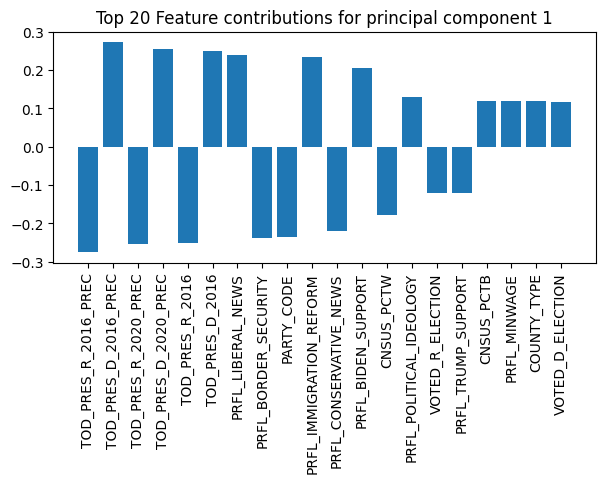

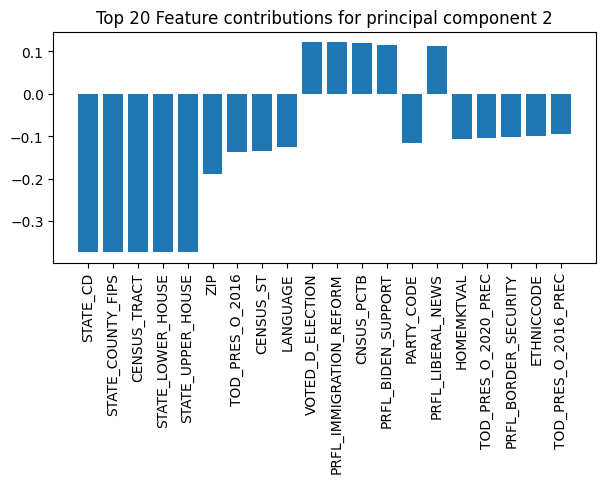

In [223]:
feature_names = surveydata.columns  
feature_names=feature_names.drop('Q1_Candidate')

top_features_list = []

# Visualize the feature contributions to the principal components

for i, component in enumerate(pca.components_):
    # Getting the top 10 features for each component
    sorted_idx = np.argsort(np.abs(component))[-20:][::-1]
    top_features = np.array(feature_names)[sorted_idx]
    top_features_list.extend(top_features)
    top_components = component[sorted_idx]

    plt.figure(figsize=(7, 3))
    plt.bar(range(20), top_components)
    plt.title(f'Top 20 Feature contributions for principal component {i+1}')
    plt.xticks(range(20), top_features, rotation=90)
    plt.show()

top_features_list = list(set(top_features_list))

# Kmeans

C:\Users\amanda.kaplan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\amanda.kaplan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


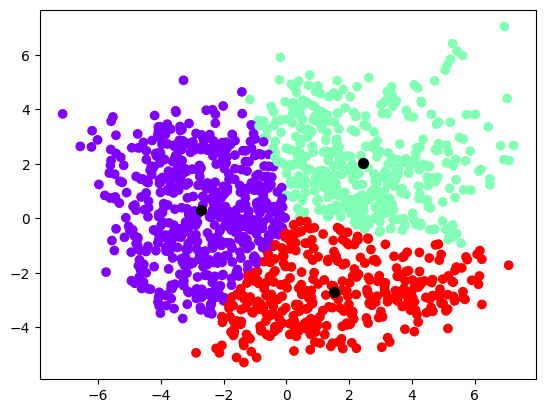

In [224]:
kmeans = KMeans(n_clusters=3)  
kmeans.fit(pca_result)
surveydata['cluster'] = kmeans.fit_predict(pca_result)

plt.scatter(pca_result[:, 0], pca_result[:, 1], c=kmeans.labels_, cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=50, c='black')


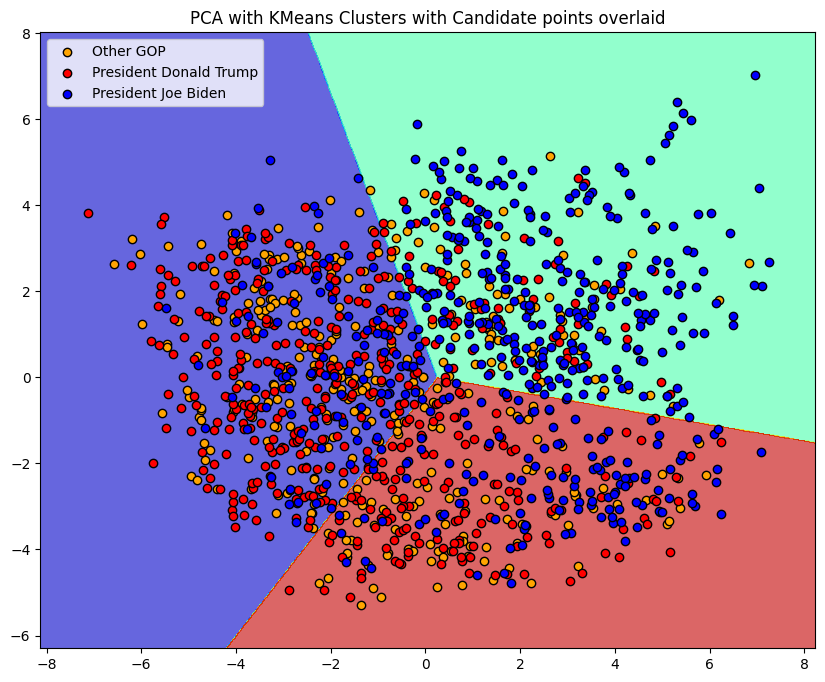

In [226]:
candidate_mapping = {
    0: 'Other GOP',
    1: 'President Donald Trump',
    2: 'President Joe Biden'
}

# Update the color_map with numeric keys
color_map = {
    0: 'orange',
    1: 'red',
    2: 'blue'
}

# Plotting
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.6, cmap="jet")

# Plot the Q1_Candidate points on top
for candidate, color in color_map.items():
    idx = surveydata['Q1_Candidate'] == candidate
    plt.scatter(pca_result[idx, 0], pca_result[idx, 1], c=color, label=candidate_mapping.get(candidate, candidate), edgecolor='black')

plt.title('PCA with KMeans Clusters with Candidate points overlaid')
plt.legend()
plt.show()


# XGBoost using the top features from PCA and the appended cluster assignment

In [227]:

top_features_list.append('cluster')

In [228]:
X_selected = surveydata[top_features_list]

In [229]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score


X_train, X_test, y_train, y_test = train_test_split(X_selected, 
                                                    surveydata['Q1_Candidate'], test_size=0.2, random_state=42)

model = xgb.XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))


Accuracy: 0.5037037037037037
              precision    recall  f1-score   support

           0       0.27      0.19      0.22        69
           1       0.47      0.57      0.51        98
           2       0.66      0.65      0.65       103

    accuracy                           0.50       270
   macro avg       0.46      0.47      0.46       270
weighted avg       0.49      0.50      0.49       270



# tuned

In [242]:
tuned_xgb2 = XGBClassifier(
    objective='multi:softmax', 
    num_class=3,  
    eval_metric='mlogloss', 
    colsample_bytree=0.8, 
    learning_rate=0.01,  
    max_depth=4, 
    n_estimators=300,  
    subsample=0.8
)

tuned_xgb2.fit(X_train, y_train)

# Making predictions
y_pred = tuned_xgb2.predict(X_test)

# Evaluating the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6037037037037037
              precision    recall  f1-score   support

           0       0.50      0.10      0.17        69
           1       0.55      0.80      0.65        98
           2       0.68      0.76      0.72       103

    accuracy                           0.60       270
   macro avg       0.58      0.55      0.51       270
weighted avg       0.59      0.60      0.55       270

